In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

import lightgbm as lgb

import xgboost as xgb
from xgboost import XGBRegressor

import catboost as cat
from catboost import CatBoostRegressor

from feature_engine.categorical_encoders import CountFrequencyCategoricalEncoder
from feature_engine.outlier_removers import Winsorizer

# for Q-Q plots
import scipy.stats as stats

pd.set_option('display.max_rows',999)
pd.set_option('display.max_columns',50)

import warnings
warnings.filterwarnings("ignore")

In [2]:
trainset = pd.read_csv('trainoutlier.csv')

In [3]:
trainset.shape

(1562, 40)

In [4]:
trainset.head()

,population,renter_occupied_households,pct_renter_occupied,evictions,rent_burden,pct_white,pct_af_am,pct_hispanic,pct_am_ind,pct_asian,pct_nh_pi,pct_multiple,pct_other,poverty_rate,pct_civilian_labor,pct_unemployment,pct_uninsured_adults,pct_uninsured_children,pct_adult_obesity,pct_adult_smoking,pct_diabetes,pct_low_birthweight,pct_excessive_drinking,pct_physical_inactivity,air_pollution_particulate_matter_value,homicides_per_100k,motor_vehicle_crash_deaths_per_100k,heart_disease_mortality_per_100k,pop_per_dentist,pop_per_primary_care_physician,pct_female,pct_below_18_years_of_age,pct_aged_65_years_and_older,pct_adults_less_than_a_high_school_diploma,pct_adults_with_high_school_diploma,pct_adults_with_some_college,pct_adults_bachelors_or_higher,birth_rate_per_1k,death_rate_per_1k,gross_rent
0,3876.0,408.0,24.583,397.410526,18.380,0.945945,0.010761,0.026038,0.005685,0.005635,0.0,0.005935,0.000000,4.172,0.550,0.023,0.107,0.062000,0.310,0.166,0.100,0.083326,0.239,0.342,11.022908,5.752414,21.715153,217.0,3421.828611,2508.303867,0.471,0.218,0.190,0.083250,0.327984,0.389168,0.199599,10.008982,9.752342,577.0
1,10224.0,1166.0,28.346,3.000000,26.694,0.808959,0.002284,0.173426,0.001803,0.001493,0.0,0.012033,0.000000,7.714,0.545,0.040,0.324,0.183375,0.253,0.102,0.066,0.070000,0.200,0.148,9.904099,5.752414,18.260000,181.0,2009.000000,1690.000000,0.472,0.290,0.077,0.099099,0.202202,0.302302,0.389872,14.482893,3.158246,844.0
2,27023.0,2927.0,21.641,9.000000,31.028,0.956621,0.005141,0.013088,0.004728,0.004708,0.0,0.014809,0.000905,9.789,0.508,0.063,0.129,0.032000,0.296,0.215,0.087,0.070000,0.187,0.258,11.011502,5.752414,19.940000,234.0,4650.000000,1350.000000,0.496,0.208,0.192,0.137725,0.387226,0.255489,0.219561,9.620346,10.873572,700.0
3,8735.0,1039.0,23.110,0.000000,27.734,0.894835,0.000298,0.076576,0.000995,0.004297,0.0,0.022999,0.000000,13.735,0.545,0.038,0.207,0.084000,0.255,0.182,0.104,0.081000,0.169,0.274,12.845770,5.752414,30.310000,231.0,4420.000000,1749.000000,0.503,0.193,0.215,0.077154,0.308617,0.398798,0.215431,9.383225,10.870809,592.0
4,3681.0,365.0,21.985,2.000000,19.673,0.923886,0.000496,0.042889,0.000000,0.013622,0.0,0.016905,0.002202,8.217,0.474,0.034,0.177,0.075000,0.324,0.118,0.113,0.083326,0.178,0.340,11.565750,5.752414,21.715153,270.0,3421.828611,1249.000000,0.516,0.222,0.230,0.092537,0.362189,0.346269,0.199005,9.543286,14.723926,444.0


In [5]:
trainset.describe()

,population,renter_occupied_households,pct_renter_occupied,evictions,rent_burden,pct_white,pct_af_am,pct_hispanic,pct_am_ind,pct_asian,pct_nh_pi,pct_multiple,pct_other,poverty_rate,pct_civilian_labor,pct_unemployment,pct_uninsured_adults,pct_uninsured_children,pct_adult_obesity,pct_adult_smoking,pct_diabetes,pct_low_birthweight,pct_excessive_drinking,pct_physical_inactivity,air_pollution_particulate_matter_value,homicides_per_100k,motor_vehicle_crash_deaths_per_100k,heart_disease_mortality_per_100k,pop_per_dentist,pop_per_primary_care_physician,pct_female,pct_below_18_years_of_age,pct_aged_65_years_and_older,pct_adults_less_than_a_high_school_diploma,pct_adults_with_high_school_diploma,pct_adults_with_some_college,pct_adults_bachelors_or_higher,birth_rate_per_1k,death_rate_per_1k,gross_rent
count,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1.562000e+03,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000
mean,49114.225672,5682.920855,28.314262,218.579743,28.517017,0.770633,0.067198,0.066712,0.004483,0.008505,0.000272,0.016060,0.000754,12.025481,0.469967,0.062230,0.219656,0.087863,0.305049,0.210151,0.106540,0.082519,0.163727,0.277053,11.637336,5.752414e+00,21.413277,275.154930,3194.120384,2280.069873,0.501964,0.228032,0.166945,0.145006,0.346525,0.303117,0.200967,11.539758,10.406163,690.869398
std,52350.312542,6284.298513,7.432344,280.348295,4.401403,0.198506,0.086364,0.065213,0.004490,0.008415,0.000379,0.009269,0.000956,5.290549,0.067345,0.021321,0.066185,0.038427,0.040905,0.054311,0.022327,0.018199,0.037713,0.052664,1.524285,8.085012e-14,9.009956,56.639382,1639.713168,1109.723035,0.014393,0.031623,0.041844,0.065225,0.070378,0.051584,0.079608,2.451829,2.727474,161.102958
min,269.000000,64.000000,8.672750,-1.000000,17.711625,0.224700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.290000,0.012000,0.053000,0.018000,0.211000,0.075000,0.047375,0.038500,0.087000,0.139500,7.209413,5.752414e+00,3.140000,116.000000,340.000000,279.000000,0.471000,0.151000,0.063500,0.019000,0.156669,0.167145,0.064128,5.626693,3.158246,351.000000
25%,10452.750000,1078.250000,22.874000,6.000000,25.869000,0.649967,0.005523,0.018747,0.001201,0.002391,0.000000,0.009465,0.000000,7.991000,0.425000,0.046000,0.172000,0.059000,0.283000,0.174000,0.092000,0.070000,0.144000,0.243000,10.443252,5.752414e+00,14.935000,233.000000,1919.250000,1429.000000,0.495000,0.208000,0.140000,0.094226,0.300601,0.269461,0.142142,10.014818,8.613691,578.000000
50%,25282.000000,2754.000000,27.199500,72.500000,28.768000,0.846542,0.020599,0.037613,0.002610,0.005279,0.000000,0.014438,0.000302,11.173500,0.470500,0.061000,0.216000,0.079000,0.306000,0.211682,0.105000,0.080000,0.164818,0.281000,11.884105,5.752414e+00,21.715153,270.000000,2889.500000,2080.000000,0.504000,0.227000,0.164500,0.129388,0.352176,0.303303,0.182365,11.435441,10.396898,650.000000
75%,68361.500000,7987.000000,32.341500,397.410526,31.307250,0.933479,0.102047,0.092998,0.006121,0.011886,0.000403,0.020999,0.001197,15.018500,0.515000,0.076000,0.265000,0.108750,0.331000,0.240000,0.121750,0.091000,0.182000,0.312000,12.879822,5.752414e+00,26.015000,311.000000,3937.250000,2747.500000,0.511000,0.246000,0.191000,0.187719,0.396556,0.337672,0.241234,12.940235,12.250655,773.750000
max,155224.625000,18350.125000,46.542750,984.526316,39.464625,0.995141,0.246833,0.204374,0.013501,0.026130,0.001007,0.038300,0.002992,25.559750,0.650000,0.121000,0.404500,0.183375,0.403000,0.339000,0.166375,0.122500,0.239000,0.415500,14.992477,5.752414e+00,42.635000,428.000000,6964.250000,4725.250000,0.535000,0.303000,0.267500,0.327959,0.535536,0.439989,0.389872,17.3283

In [6]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1562 entries, 0 to 1561
Data columns (total 40 columns):
population                                    1562 non-null float64
renter_occupied_households                    1562 non-null float64
pct_renter_occupied                           1562 non-null float64
evictions                                     1562 non-null float64
rent_burden                                   1562 non-null float64
pct_white                                     1562 non-null float64
pct_af_am                                     1562 non-null float64
pct_hispanic                                  1562 non-null float64
pct_am_ind                                    1562 non-null float64
pct_asian                                     1562 non-null float64
pct_nh_pi                                     1562 non-null float64
pct_multiple                                  1562 non-null float64
pct_other                                     1562 non-null float64
poverty_r

In [7]:
array = trainset.values

In [8]:
array

array([[3.87600000e+03, 4.08000000e+02, 2.45830000e+01, ...,
        1.00089824e+01, 9.75234185e+00, 5.77000000e+02],
       [1.02240000e+04, 1.16600000e+03, 2.83460000e+01, ...,
        1.44828927e+01, 3.15824596e+00, 8.44000000e+02],
       [2.70230000e+04, 2.92700000e+03, 2.16410000e+01, ...,
        9.62034648e+00, 1.08735717e+01, 7.00000000e+02],
       ...,
       [7.72240000e+04, 4.67700000e+03, 1.89280000e+01, ...,
        9.02928647e+00, 8.84661304e+00, 7.54000000e+02],
       [4.69800000e+03, 4.02000000e+02, 2.01070000e+01, ...,
        8.44521438e+00, 9.74447813e+00, 6.40000000e+02],
       [1.55224625e+05, 1.83501250e+04, 3.77890000e+01, ...,
        1.39446283e+01, 6.17315807e+00, 9.76000000e+02]])

In [9]:
X_num = array[:,0:39]
y_num = array[:,39]

In [10]:
X_num.shape

(1562, 39)

In [11]:
y_num.shape

(1562,)

### Tree Based Method Feature Selection

In [12]:
rf = RandomForestRegressor(n_estimators=100,criterion='mae',n_jobs=-1)

In [13]:
rfFit = rf.fit(X_num,y_num)

In [14]:
print(rfFit.feature_importances_)

[0.15449098 0.01994121 0.01632639 0.0113488  0.02074342 0.01695848
 0.01265255 0.02565592 0.01341026 0.0612862  0.00597848 0.01970347
 0.02097368 0.03512591 0.01390714 0.01680808 0.01041592 0.01662681
 0.04468725 0.01339806 0.01162736 0.00676592 0.01055584 0.02944094
 0.01649416 0.         0.01114115 0.01514627 0.01320416 0.01036425
 0.01150222 0.0128876  0.03410288 0.0158944  0.0289328  0.01580926
 0.12067924 0.01553448 0.06947807]


In [15]:
print(trainset.columns)

Index(['population', 'renter_occupied_households', 'pct_renter_occupied',
       'evictions', 'rent_burden', 'pct_white', 'pct_af_am', 'pct_hispanic',
       'pct_am_ind', 'pct_asian', 'pct_nh_pi', 'pct_multiple', 'pct_other',
       'poverty_rate', 'pct_civilian_labor', 'pct_unemployment',
       'pct_uninsured_adults', 'pct_uninsured_children', 'pct_adult_obesity',
       'pct_adult_smoking', 'pct_diabetes', 'pct_low_birthweight',
       'pct_excessive_drinking', 'pct_physical_inactivity',
       'air_pollution_particulate_matter_value', 'homicides_per_100k',
       'motor_vehicle_crash_deaths_per_100k',
       'heart_disease_mortality_per_100k', 'pop_per_dentist',
       'pop_per_primary_care_physician', 'pct_female',
       'pct_below_18_years_of_age', 'pct_aged_65_years_and_older',
       'pct_adults_less_than_a_high_school_diploma',
       'pct_adults_with_high_school_diploma', 'pct_adults_with_some_college',
       'pct_adults_bachelors_or_higher', 'birth_rate_per_1k',
       'd

**'population'; 'pct_adults_bachelors_or_higher','pct_asian','pct_adult_obesity',**

In [16]:
et = ExtraTreesRegressor(n_estimators=100,criterion='mae',n_jobs=-1)
etFit = et.fit(X_num,y_num)

In [17]:
etFit.feature_importances_

array([0.13585338, 0.06322014, 0.01801432, 0.01533629, 0.01826817,
       0.0164645 , 0.01432487, 0.02569801, 0.01326366, 0.06086027,
       0.01203916, 0.01992748, 0.02415425, 0.03284488, 0.01519819,
       0.01626476, 0.0120515 , 0.01612722, 0.03119168, 0.01977014,
       0.01448524, 0.01079016, 0.01402851, 0.02593422, 0.01592339,
       0.        , 0.0125504 , 0.0175961 , 0.01416363, 0.01192243,
       0.01370031, 0.01343855, 0.0280865 , 0.01404942, 0.024827  ,
       0.01558188, 0.09981973, 0.0151213 , 0.05710837])

In [18]:
trainset.columns

Index(['population', 'renter_occupied_households', 'pct_renter_occupied',
       'evictions', 'rent_burden', 'pct_white', 'pct_af_am', 'pct_hispanic',
       'pct_am_ind', 'pct_asian', 'pct_nh_pi', 'pct_multiple', 'pct_other',
       'poverty_rate', 'pct_civilian_labor', 'pct_unemployment',
       'pct_uninsured_adults', 'pct_uninsured_children', 'pct_adult_obesity',
       'pct_adult_smoking', 'pct_diabetes', 'pct_low_birthweight',
       'pct_excessive_drinking', 'pct_physical_inactivity',
       'air_pollution_particulate_matter_value', 'homicides_per_100k',
       'motor_vehicle_crash_deaths_per_100k',
       'heart_disease_mortality_per_100k', 'pop_per_dentist',
       'pop_per_primary_care_physician', 'pct_female',
       'pct_below_18_years_of_age', 'pct_aged_65_years_and_older',
       'pct_adults_less_than_a_high_school_diploma',
       'pct_adults_with_high_school_diploma', 'pct_adults_with_some_college',
       'pct_adults_bachelors_or_higher', 'birth_rate_per_1k',
       'd

**'population', 'renter_occupied_households', 'poverty_rate','pct_adults_with_high_school_diploma','pct_adults_bachelors_or_higher','death_rate_per_1k',**

### Using LightGBM

In [19]:
trainingdata = lgb.Dataset(data=X_num, label=y_num)
params = {}
params['learning_rate'] = 0.1
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = ['mean_absolute_error']

lgbmodel = lgb.train(params=params,train_set=trainingdata,num_boost_round=100)

In [20]:
lgbmodel.feature_importance()

array([123,  74,  82,  52, 126, 116,  59,  98,  86,  83,  24,  93,  49,
       177,  78,  80,  74,  91,  66,  66,  64,  27,  44,  79, 111,   0,
        47,  64,  57,  68,  64,  63,  89,  78,  74,  78,  88,  89, 119])

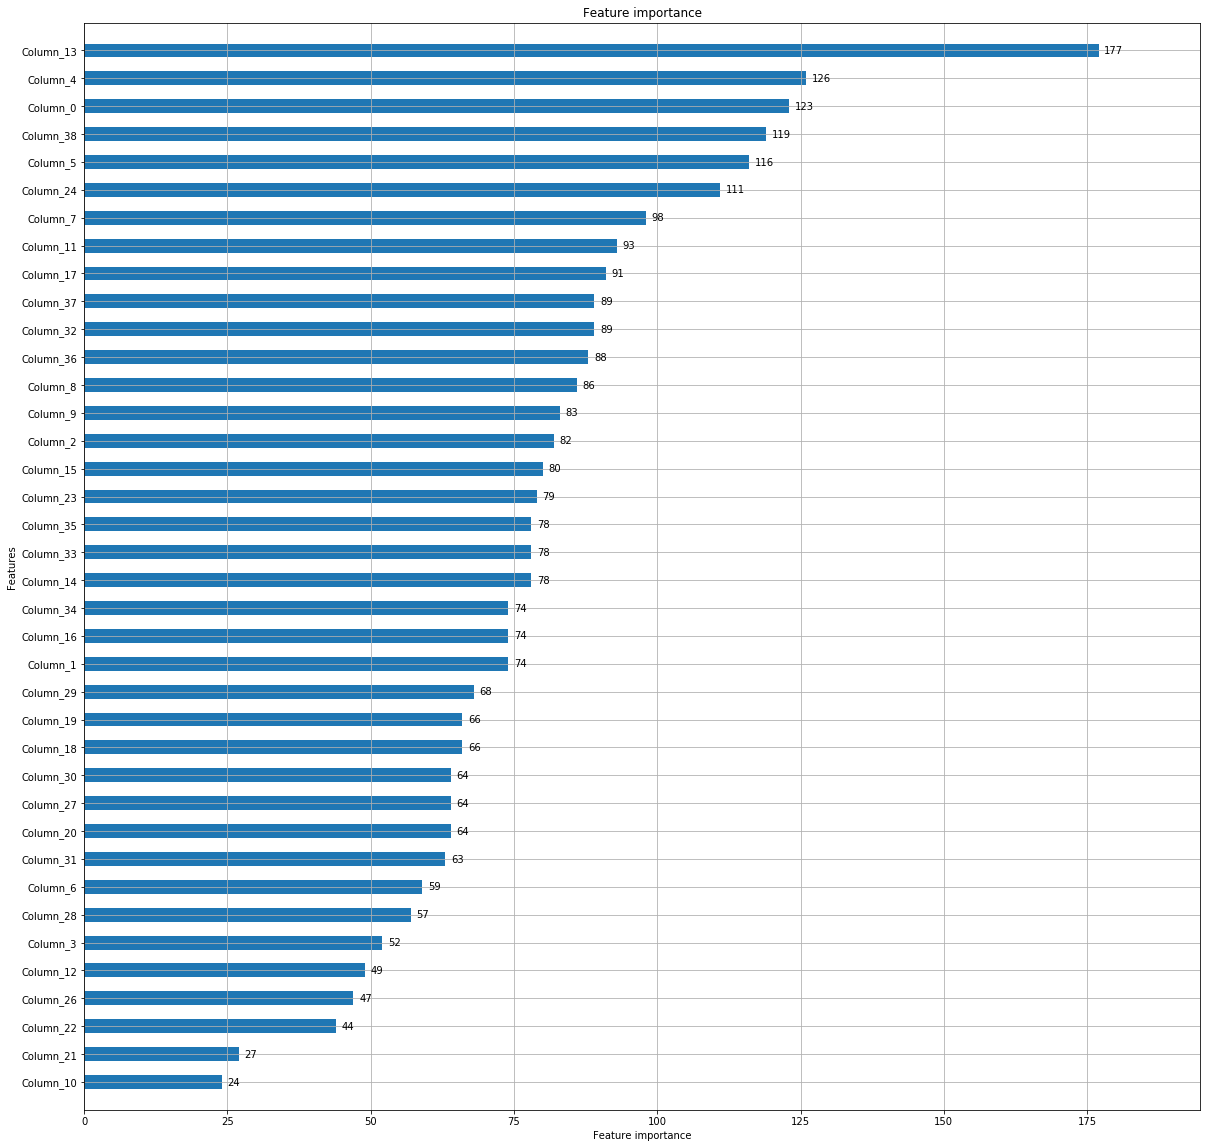

In [21]:
lgb.plot_importance(lgbmodel,height=0.5, figsize=(20,20))
plt.show()

In [22]:
trainset.columns

Index(['population', 'renter_occupied_households', 'pct_renter_occupied',
       'evictions', 'rent_burden', 'pct_white', 'pct_af_am', 'pct_hispanic',
       'pct_am_ind', 'pct_asian', 'pct_nh_pi', 'pct_multiple', 'pct_other',
       'poverty_rate', 'pct_civilian_labor', 'pct_unemployment',
       'pct_uninsured_adults', 'pct_uninsured_children', 'pct_adult_obesity',
       'pct_adult_smoking', 'pct_diabetes', 'pct_low_birthweight',
       'pct_excessive_drinking', 'pct_physical_inactivity',
       'air_pollution_particulate_matter_value', 'homicides_per_100k',
       'motor_vehicle_crash_deaths_per_100k',
       'heart_disease_mortality_per_100k', 'pop_per_dentist',
       'pop_per_primary_care_physician', 'pct_female',
       'pct_below_18_years_of_age', 'pct_aged_65_years_and_older',
       'pct_adults_less_than_a_high_school_diploma',
       'pct_adults_with_high_school_diploma', 'pct_adults_with_some_college',
       'pct_adults_bachelors_or_higher', 'birth_rate_per_1k',
       'd

In [23]:
colname = pd.DataFrame(trainset.columns)

In [24]:
colname

,0
0,population
1,renter_occupied_households
2,pct_renter_occupied
3,evictions
4,rent_burden
5,pct_white
6,pct_af_am
7,pct_hispanic
8,pct_am_ind
9,pct_asian


In [25]:
colname = colname.drop([39])

In [26]:
result = pd.DataFrame(lgbmodel.feature_importance())

In [27]:
result = result.astype('object')

In [28]:
result

,0
0,123
1,74
2,82
3,52
4,126
5,116
6,59
7,98
8,86
9,83


In [29]:
df_col = pd.concat([colname,result], axis=1)

In [30]:
df_col

,0,0
0,population,123
1,renter_occupied_households,74
2,pct_renter_occupied,82
3,evictions,52
4,rent_burden,126
5,pct_white,116
6,pct_af_am,59
7,pct_hispanic,98
8,pct_am_ind,86
9,pct_asian,83


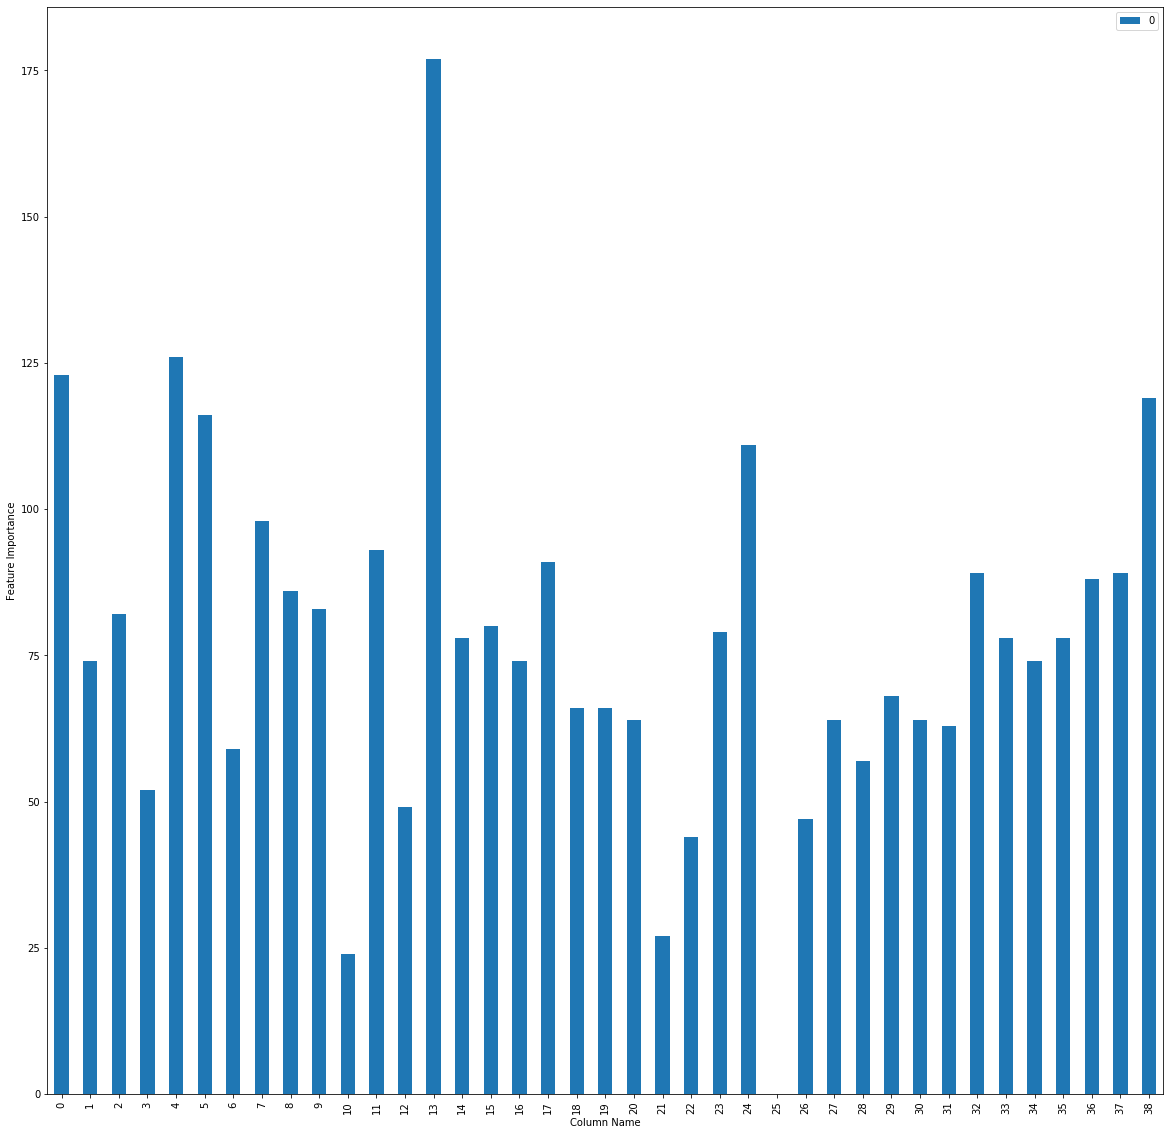

In [31]:
df_col.plot(kind='bar',figsize=(20,20))
plt.xlabel("Column Name")
plt.ylabel("Feature Importance")
plt.show()

**poverty_rate, rent_burden, pct_white, pct_hispanic, pct_multiple, pct_uninsured_children, death_rate_per_1k**

### Using XGBoost

In [32]:
xgbreg = xgb.XGBRegressor(objective ='reg:squarederror')
xgbreg.fit(X_num,y_num)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [33]:
print(xgbreg.feature_importances_)

[0.07696298 0.01660992 0.00386867 0.01424391 0.00868824 0.02070882
 0.00626704 0.02989123 0.0057078  0.23172656 0.01191149 0.01876272
 0.03015751 0.02051348 0.00317424 0.01905219 0.00479165 0.00715215
 0.02423142 0.00420569 0.00830371 0.00435355 0.00536007 0.02929649
 0.00589588 0.         0.00895178 0.00218779 0.00625225 0.00286753
 0.00486453 0.00283667 0.0187937  0.00682547 0.10440589 0.00490498
 0.15161568 0.00452955 0.0691267 ]


In [34]:
print(trainset.columns)

Index(['population', 'renter_occupied_households', 'pct_renter_occupied',
       'evictions', 'rent_burden', 'pct_white', 'pct_af_am', 'pct_hispanic',
       'pct_am_ind', 'pct_asian', 'pct_nh_pi', 'pct_multiple', 'pct_other',
       'poverty_rate', 'pct_civilian_labor', 'pct_unemployment',
       'pct_uninsured_adults', 'pct_uninsured_children', 'pct_adult_obesity',
       'pct_adult_smoking', 'pct_diabetes', 'pct_low_birthweight',
       'pct_excessive_drinking', 'pct_physical_inactivity',
       'air_pollution_particulate_matter_value', 'homicides_per_100k',
       'motor_vehicle_crash_deaths_per_100k',
       'heart_disease_mortality_per_100k', 'pop_per_dentist',
       'pop_per_primary_care_physician', 'pct_female',
       'pct_below_18_years_of_age', 'pct_aged_65_years_and_older',
       'pct_adults_less_than_a_high_school_diploma',
       'pct_adults_with_high_school_diploma', 'pct_adults_with_some_college',
       'pct_adults_bachelors_or_higher', 'birth_rate_per_1k',
       'd

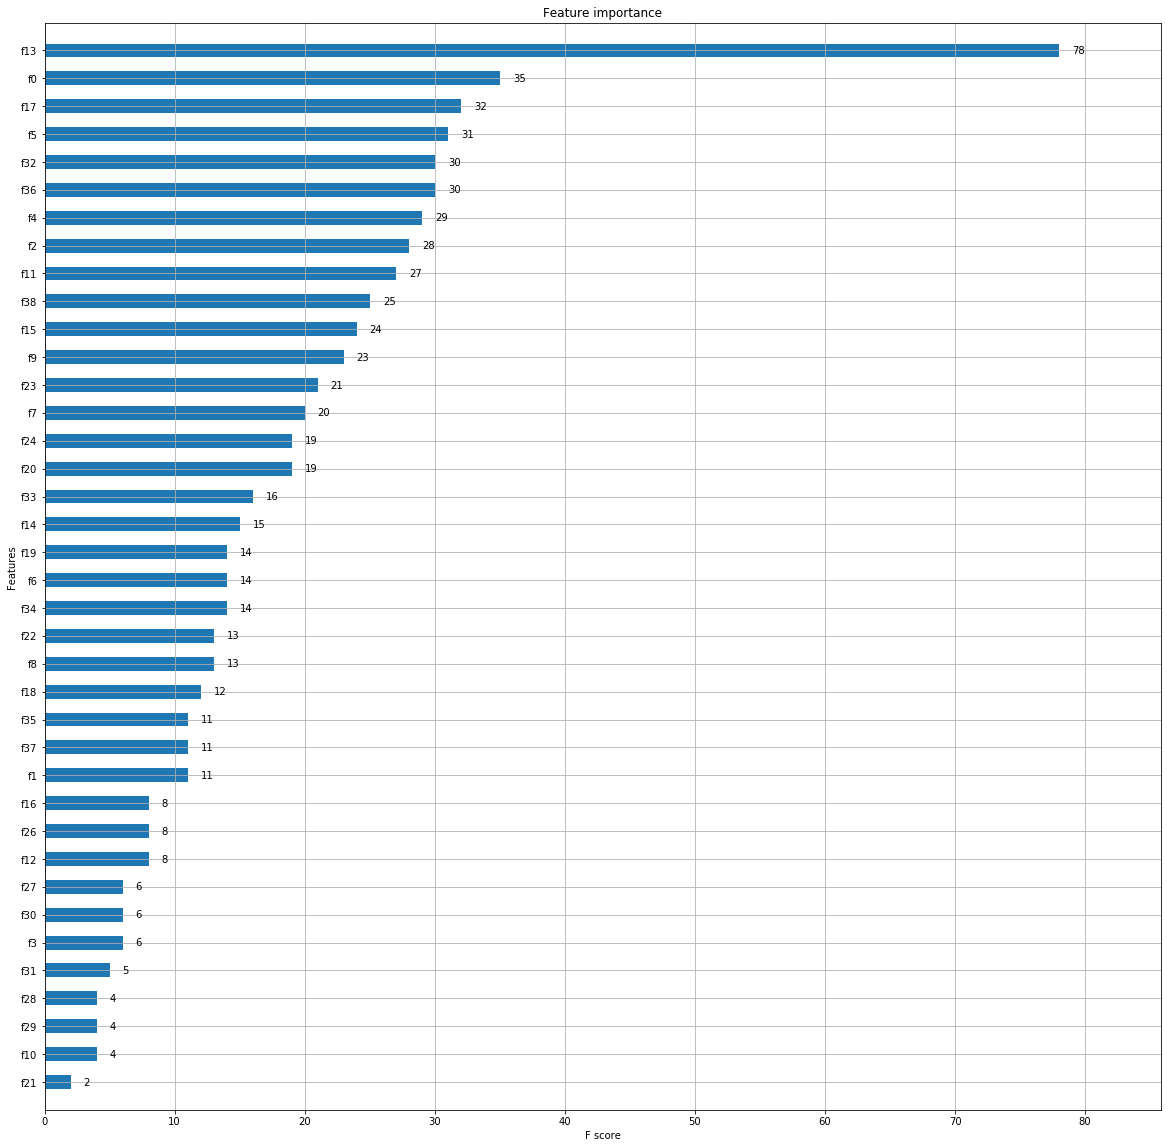

In [35]:
ax = xgb.plot_importance(xgbreg,height=0.5)
fig = ax.figure
fig.set_size_inches(20,20)

In [36]:
colname = pd.DataFrame(trainset.columns)

In [37]:
colname

,0
0,population
1,renter_occupied_households
2,pct_renter_occupied
3,evictions
4,rent_burden
5,pct_white
6,pct_af_am
7,pct_hispanic
8,pct_am_ind
9,pct_asian


In [38]:
result = pd.DataFrame(xgbreg.feature_importances_)

In [39]:
result

,0
0,0.076963
1,0.016610
2,0.003869
3,0.014244
4,0.008688
5,0.020709
6,0.006267
7,0.029891
8,0.005708
9,0.231727


In [40]:
df_col2 = pd.concat([colname,result], axis=1)

In [41]:
df_col2

,0,0
0,population,0.076963
1,renter_occupied_households,0.016610
2,pct_renter_occupied,0.003869
3,evictions,0.014244
4,rent_burden,0.008688
5,pct_white,0.020709
6,pct_af_am,0.006267
7,pct_hispanic,0.029891
8,pct_am_ind,0.005708
9,pct_asian,0.231727


**poverty_rate, population, pct_white, pct_uninsured_children, rent_burden, pct_multiple,death_rate_per_1k**

### Using Catboost

In [42]:
catreg = cat.CatBoostRegressor(iterations=100,loss_function='MAE')
catreg.fit(X_num,y_num)

0:	learn: 121.7098591	total: 178ms	remaining: 17.6s
1:	learn: 119.5400719	total: 190ms	remaining: 9.32s
2:	learn: 117.4076754	total: 199ms	remaining: 6.42s
3:	learn: 115.4473218	total: 208ms	remaining: 5s
4:	learn: 113.5598670	total: 216ms	remaining: 4.1s
5:	learn: 111.6534567	total: 224ms	remaining: 3.5s
6:	learn: 109.8545570	total: 231ms	remaining: 3.07s
7:	learn: 108.1035615	total: 239ms	remaining: 2.74s
8:	learn: 106.3330600	total: 247ms	remaining: 2.5s
9:	learn: 104.6934853	total: 256ms	remaining: 2.3s
10:	learn: 103.0402074	total: 264ms	remaining: 2.13s
11:	learn: 101.4477034	total: 272ms	remaining: 2s
12:	learn: 99.9702937	total: 279ms	remaining: 1.87s
13:	learn: 98.4723399	total: 287ms	remaining: 1.76s
14:	learn: 97.0377811	total: 294ms	remaining: 1.67s
15:	learn: 95.7171044	total: 301ms	remaining: 1.58s
16:	learn: 94.3814347	total: 310ms	remaining: 1.51s
17:	learn: 93.2383199	total: 319ms	remaining: 1.45s
18:	learn: 92.1417033	total: 330ms	remaining: 1.41s
19:	learn: 91.037069

In [43]:
catreg.best_score_

{'learn': {'MAE': 54.50921763749066}}

In [44]:
catreg.score(X_num,y_num)

0.7887677480232305

In [45]:
print(catreg.feature_importances_)

[10.3969465   4.31531886  1.00325887  1.54726677  2.44765352  4.36450245
  1.48819484  4.01241431  1.63897427  4.21798552  1.08940648  1.32249817
  1.90964391  9.22290397  1.20853162  2.10754418  1.10186645  2.16189198
  3.00797049  0.48712483  1.41571618  0.23226888  0.38520496  4.42077628
  1.19659693  0.          0.3954504   1.4654702   1.70140343  0.26838868
  0.49004479  0.28192962  2.39619878  1.12502102  4.48654156  1.34454959
  8.63703345  0.46206142 10.24344586]


In [46]:
print(trainset.columns)

Index(['population', 'renter_occupied_households', 'pct_renter_occupied',
       'evictions', 'rent_burden', 'pct_white', 'pct_af_am', 'pct_hispanic',
       'pct_am_ind', 'pct_asian', 'pct_nh_pi', 'pct_multiple', 'pct_other',
       'poverty_rate', 'pct_civilian_labor', 'pct_unemployment',
       'pct_uninsured_adults', 'pct_uninsured_children', 'pct_adult_obesity',
       'pct_adult_smoking', 'pct_diabetes', 'pct_low_birthweight',
       'pct_excessive_drinking', 'pct_physical_inactivity',
       'air_pollution_particulate_matter_value', 'homicides_per_100k',
       'motor_vehicle_crash_deaths_per_100k',
       'heart_disease_mortality_per_100k', 'pop_per_dentist',
       'pop_per_primary_care_physician', 'pct_female',
       'pct_below_18_years_of_age', 'pct_aged_65_years_and_older',
       'pct_adults_less_than_a_high_school_diploma',
       'pct_adults_with_high_school_diploma', 'pct_adults_with_some_college',
       'pct_adults_bachelors_or_higher', 'birth_rate_per_1k',
       'd

In [47]:
X_display = trainset

In [48]:
X_display = X_display.drop(['gross_rent'],axis=1)

In [49]:
X_display

,population,renter_occupied_households,pct_renter_occupied,evictions,rent_burden,pct_white,pct_af_am,pct_hispanic,pct_am_ind,pct_asian,pct_nh_pi,pct_multiple,pct_other,poverty_rate,pct_civilian_labor,pct_unemployment,pct_uninsured_adults,pct_uninsured_children,pct_adult_obesity,pct_adult_smoking,pct_diabetes,pct_low_birthweight,pct_excessive_drinking,pct_physical_inactivity,air_pollution_particulate_matter_value,homicides_per_100k,motor_vehicle_crash_deaths_per_100k,heart_disease_mortality_per_100k,pop_per_dentist,pop_per_primary_care_physician,pct_female,pct_below_18_years_of_age,pct_aged_65_years_and_older,pct_adults_less_than_a_high_school_diploma,pct_adults_with_high_school_diploma,pct_adults_with_some_college,pct_adults_bachelors_or_higher,birth_rate_per_1k,death_rate_per_1k
0,3876.000,408.000,24.583,397.410526,18.380000,0.945945,0.010761,0.026038,0.005685,0.005635,0.000000,0.005935,0.000000,4.172,0.550,0.023,0.107,0.062000,0.310,0.166000,0.100,0.083326,0.239000,0.342,11.022908,5.752414,21.715153,217.0,3421.828611,2508.303867,0.471,0.218,0.190,0.083250,0.327984,0.389168,0.199599,10.008982,9.752342
1,10224.000,1166.000,28.346,3.000000,26.694000,0.808959,0.002284,0.173426,0.001803,0.001493,0.000000,0.012033,0.000000,7.714,0.545,0.040,0.324,0.183375,0.253,0.102000,0.066,0.070000,0.200000,0.148,9.904099,5.752414,18.260000,181.0,2009.000000,1690.000000,0.472,0.290,0.077,0.099099,0.202202,0.302302,0.389872,14.482893,3.158246
2,27023.000,2927.000,21.641,9.000000,31.028000,0.956621,0.005141,0.013088,0.004728,0.004708,0.000000,0.014809,0.000905,9.789,0.508,0.063,0.129,0.032000,0.296,0.215000,0.087,0.070000,0.187000,0.258,11.011502,5.752414,19.940000,234.0,4650.000000,1350.000000,0.496,0.208,0.192,0.137725,0.387226,0.255489,0.219561,9.620346,10.873572
3,8735.000,1039.000,23.110,0.000000,27.734000,0.894835,0.000298,0.076576,0.000995,0.004297,0.000000,0.022999,0.000000,13.735,0.545,0.038,0.207,0.084000,0.255,0.182000,0.104,0.081000,0.169000,0.274,12.845770,5.752414,30.310000,231.0,4420.000000,1749.000000,0.503,0.193,0.215,0.077154,0.308617,0.398798,0.215431,9.383225,10.870809
4,3681.000,365.000,21.985,2.000000,19.673000,0.923886,0.000496,0.042889,0.000000,0.013622,0.000000,0.016905,0.002202,8.217,0.474,0.034,0.177,0.075000,0.324,0.118000,0.113,0.083326,0.178000,0.340,11.565750,5.752414,21.715153,270.0,3421.828611,1249.000000,0.516,0.222,0.230,0.092537,0.362189,0.346269,0.199005,9.543286,14.723926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1557,18983.000,1480.000,22.621,41.000000,26.905000,0.847652,0.064786,0.048670,0.000000,0.012277,0.001007,0.024815,0.000000,5.699,0.517,0.044,0.216,0.086000,0.302,0.211682,0.096,0.079000,0.164818,0.227,12.942281,5.752414,28.940000,207.0,6299.000000,4660.000000,0.510,0.243,0.144,0.153614,0.347390,0.263052,0.235944,11.369618,7.211285
1558,18837.000,2144.000,28.649,7.000000,26.515000,0.925500,0.010666,0.028790,0.000398,0.020893,0.001007,0.012667,0.000000,6.789,0.559,0.043,0.112,0.038000,0.294,0.169000,0.081,0.060000,0.166000,0.242,10.669456,5.752414,18.020000,272.0,2030.000000,1249.000000,0.510,0.205,0.193,0.070858,0.371257,0.311377,0.246507,9.330009,12.600874
1559,77224.000,4677.000,18.928,137.000000,28.827000,0.883936,0.070858,0.019081,0.000614,0.012569,0.000302,0.011835,0.000805,6.294,0.498,0.051,0.172,0.071000,0.260,0.193000,0.096,0.080000,0.168000,0.298,12.962100,5.752414,13.780000,237.0,6964.250000,1529.000000,0.503,0.211,0.179,0.118644,0.311067,0.302094,0.268195,9.029286,8.846613
1560,4698.000,402.000,20.107,1.000000,39.464625,0.224700,0.000911,0.204374,0.000401,0.000000,0.000000,0.000000,0.000200,17.300,0.493,0.112,0.273,0.129000,0.235,0.171000,0.099,0.110000,0.131000,0.246,10.244994,5.752414,21.715153,192.0,4710.000000,2508.303867,0.484,0.195,0.206,0.164000,0.354000,0.342000,0.140000,8.445214,9.744478


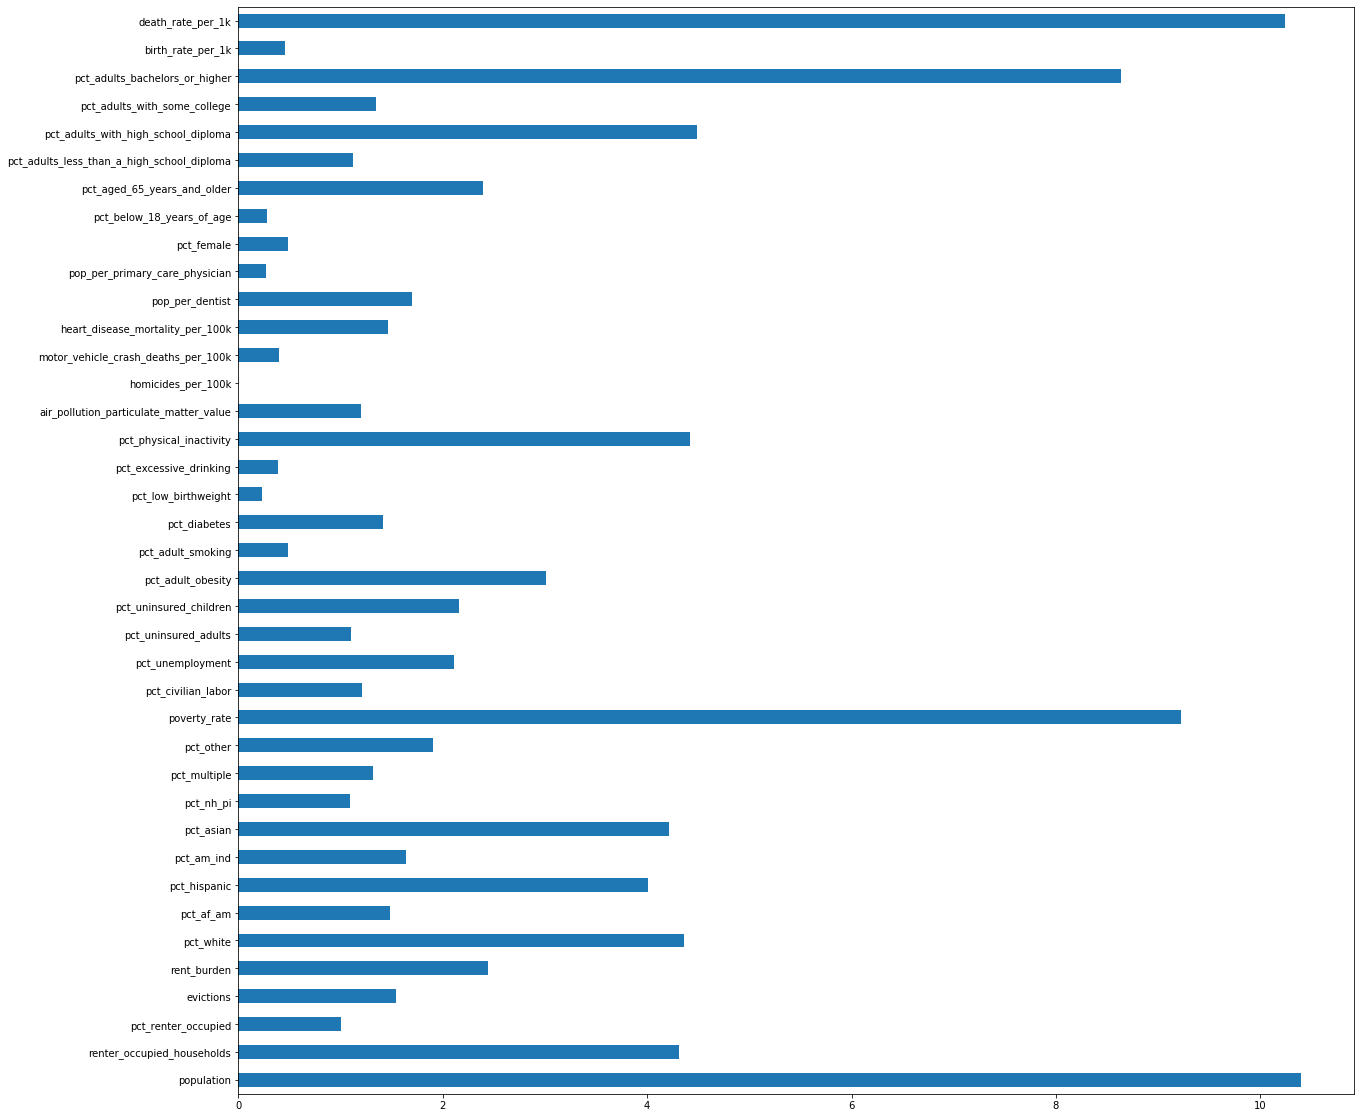

In [50]:
plt.figure(figsize=(20,20))
feat_importances = pd.Series(catreg.feature_importances_, index=X_display.columns)
feat_importances.plot(kind='barh')
plt.show()

**population, poverty_rate, death_rate_per_1k, pct_adults_bachelors_or_higher, pct_physical_inactivity, pct_hispanic, 'renter_occupied_households'**